# Working with molecules in Python: OpenEye toolkits, 3D structures, and shape overlays

Often, we have a molecule or set of molecules we would like to work with as part of some workflow, and we need a way to load the molecule so we can interact with it. Perhaps we only have its name, or [SMILES string](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). Or maybe we have it in a line-drawing format such as from ChemDraw, MarvinSketch, or ChemDoodle. Or maybe we have the molecule from a co-crystal structure with a protein - so we have the approximate coordinates of heavy atoms but we are missing bonding information and proton coordinates. Regardless, we will typically want to load this molecule and be able to manipulate it. Let's assume here we do NOT have the full 3D coordinates of all of the atoms. So we will need to generate these somehow.

For today's class, we will consider a couple simple problems which are useful in their own right, and help provide an intro into the [OpenEye toolkits](www.eyesopen.com) which we will use for manipulating molecules in this class:
1. Loading molecules from files/names/SMILES
2. Generating 3D conformations
3. Doing shape overlays 
4. Writing out the final molecules

Before getting carried away on this, though, I should point out that the [OpenEye Python toolkit documentation](http://docs.eyesopen.com/toolkits/python/) is readily available, and they also have a [cookbook](https://docs.eyesopen.com/toolkits/cookbook/python/) with a variety of interesting examples.

## Here we will draw mainly on five OpenEye toolkits
* OEChem: The generic OpenEye chemistry toolkit, for working with molecules (reading/writing, traversing atoms/bonds, etc)
* OEOmega: Omega is OpenEye's toolkit for working with molecular conformations/generating 3D conformations
* OEShape: Their shape toolkit, for doing things like shape overlays of molecules
* OEIUPAC: For working with chemical naming
* OEDepict: For depiction of small molecules

We need to start off by importing these so we can work with them here (REMINDER: be sure to shift-enter/hit play in the box below to evaluate it so that you import these for yourself):

In [1]:
from openeye.oechem import *
from openeye.oeiupac import *
from openeye.oeomega import *
from openeye.oeshape import *
from openeye.oedepict import *

## Not everyone will have ChemDraw, so I like to recommend MarvinSketch
* There's an [online (web-based) version](https://www.chemaxon.com/marvin/sketch/index.php)
* As well as a [free downloadable version](https://www.chemaxon.com/products/marvin/marvinsketch/)

With Marvin you should be able to easily make some molecules and download them in various formats for manipulating here. Draw a molecule you'd like to work on, then you can access it in several formats:
* For SMILES: Select the molecule, choose "Edit">"Copy as Smiles"
* For compound name: Choose "Structure">"Structure to name">"Generate name"
* For a file: Select the molecule, choose "File">"Save as..." and select your file format. MDL .mol files are fairly universal.

Below, we'll look at examples of loading molecules from all three formats using the OpenEye toolkits. As a starting point let's take this molecule drawn in Marvin:

<img src="Marvin_molecule.png">

We obtain the SMILES and compound name ("CC1=CC2=C(C=C1)C(Cl)=CC=C2" and "1-chloro-6-methylnapthalene", respectively) and I exported the molecule to "Marvin_molecule.mol".


## Next we load the molecule 

Now we move to Python to load the molecule:

In [2]:
#First, we create an empty OEChem molecule object which we will store our molecule into
mol_from_smiles = OEMol()

#Next we grab our SMILES string from Marvin
smiles = "CC1=CC2=C(C=C1)C(Cl)=CC=C2"

#Then we parse the SMILES string
OEParseSmiles(mol_from_smiles, smiles)

#If successful, we should see no error message and the function will output 'True'. 
#We could catch this in a variable if we wanted.


True

In [3]:
#Next, let's work from the IUPAC name
mol_from_name = OEMol()

#Store our name
name = "1-chloro-6-methylnapthalene"

#Parse the name
OEParseIUPACName(mol_from_name, name)

#Again, if successful, we should see no error message and the function will output 'True'.

True

In [4]:
#Finally, let's proceed to reading our molecule in from a file

#First, we need to initialize an OpenEye "molecule stream" to read from a file - in this case an input stream
istream = oemolistream( 'Marvin_molecule.mol') #oemolistream is an openeye molecule input stream. We name it istream

#Next we create a molecule object
mol_from_file = OEMol()

#We read the molecule
OEReadMolecule( istream, mol_from_file)

#Close our file
istream.close()

#Here there should be no message if successful.

## We can also draw molecules from the OpenEye toolkits!

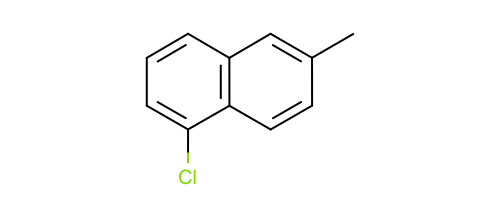

In [5]:
# Import Image from Ipython
from IPython.display import Image

# Set width, height, and whether or not to display hydrogens
width=500
height=200
supH = True #Suppress hydrogens?

# Prepare depiction/options
mol = oechem.OEMol(mol_from_smiles) # Create new OEMol; without this, it might flatten your molecule
dopt = OEPrepareDepictionOptions()
dopt.SetDepictOrientation( OEDepictOrientation_Horizontal)
dopt.SetSuppressHydrogens(supH)
OEPrepareDepiction(mol, dopt)
opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale)
disp = OE2DMolDisplay(mol, opts)
img = OEImage(width, height)
OERenderMolecule(img,disp)

# Actually generate image
Image(OEWriteImageToString("png",img))

### A quick comment on generality: Use SMILES or files whenever possible
It is worth noting that the most generally useful of these approaches are those involving SMILES strings and files. Chemical names quickly become rather difficult to parse, and it's not too difficult to come up with molecules which can't be handled by automatic name parsing or generation tools. This is especially true when going between software packages - for example, I can easily come up with compounds that Marvin can name with names that the OpenEye tools can't understand or vise versa. In large part, this is simply because chemical names are not a very efficient or easily-interpretable way of representing compounds. SMILES are a far simpler one-dimensional representation, and if 2D or 3D info is needed, files are far preferable.

### Next, we should make sure our molecules actually parsed properly. Let's do so by asking for some very simple information about each of them to make sure it matches:

In [6]:
#First, we set up a 'for' loop over the three molecules we generated so we can apply the same commands to each
for mol in [mol_from_smiles, mol_from_name, mol_from_file]:
    #Now let's print some properties of our molecule
    print("Number of atoms: ", mol.NumAtoms())
    

Number of atoms:  12
Number of atoms:  12
Number of atoms:  12


### Let's do a quick exercise: Check that this worked properly by checking the atomic number of your atoms
__Use the OpenEye toolkit [documentation on atom properties](http://docs.eyesopen.com/toolkits/python/oechemtk/atomproperties.html), plus the example code snippet below, to update the code above to print out the atomic number of all the atoms__. 

The code snippet is intended to illustrate how you can use a `for` loop to traverse the atoms within a molecule (in this case, with a boring result):

In [29]:
for atom in mol.GetAtoms():
    print(atom.GetFormalCharge())
    

0
0
0
0
0
0
0
0
0
0
0
0


## Next, we want to generate 3D coordinates for our molecule. At this point, all we have is a 1D or 2D representation of the Chemistry. 
Molecules are inherently three-dimensional, but at this point all we have is flat (one- or two-dimensional) information about our molecules. To move forward - doing any type of modeling or visualization aside from using a 2D viewer like ChemDraw or Marvin - we need to generate 3D coordinates. Even if we are going to feed our molecule into QM software to do some calculations, we still need an initial structure. Where do we get it?

The OpenEye toolkits provide a starting point via Omega, a tool for building up a reasonable estimate of the likely solvated conformations of a molecule out of molecular fragment libraries. More on the theory is available in the [Omega theory documentation](http://docs.eyesopen.com/toolkits/python/omegatk/omegatheory.html).

So here, let's go ahead and generate a 3D conformation of our molecule:

In [30]:
#First we set up Omega
omega = OEOmega() #Initialize class
omega.SetMaxConfs(1) #Only generate one conformer for our molecule
omega.SetStrictStereo(False) #Set to False to pick random stereoisomer if stereochemistry is not specified (not relevant here)
omega.SetStrictAtomTypes(False) #Be a little loose about atom typing to ensure parameters are available to omega for all molecules

#Let's create a new molecule from our old molecule
mol = OEMol(mol_from_file)

#Now we generate conformations for our molecule from above. 
omega(mol)
print(mol.NumAtoms())

#If this works properly, you should get a number below
#You might notice that it differs from the number you got above. Why?

21


### Let's also write this molecule out so you can visualize it in a molecular viewer like PyMol

In [31]:
#First we create an output stream (just like we did for an input stream)
ostream = oemolostream( 'mymolecule.mol2')
#Now we write our molecule
OEWriteMolecule(ostream, mol)
#And close the output stream
ostream.close()

## Next, we move to considering shape overlays (an aspect of ligand-based design) which we will discuss more later


### Shape overlays can provide valuable information on the structure of an active site or binding pocket
Shape overlays are motivated based on the idea that ligands of the same receptor often bear substantial 3D shape and chemical similarity, despite substantial differences in two-dimensional structure. Thus looking at the likely shape of ligands which bind to a receptor can provide valuable information on binding site shape and structure, even in the absence of detailed information about the structure of the receptor.

<img src = "morphine_tramadol.png">
This figure, from [Sun et al., Drug Discov Today. 2012 Apr; 17(7-8): 310–324.](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3328312/), shows the shape overlay of tramadol onto morphine. Despite not having obvious chemical similarity, they have very high shape similarity. This provides an early example of "scaffold hopping", where the basic scaffold of a molecule is dramatically changed while retaining activity agains the same target. 

### Let's try and reproduce the shape overlay from Sun et al. to see how this ought to work. We start by generating the molecules:

In [32]:
#Let's first generate morphine and tramadol from their names
morphine= OEMol()
OEParseIUPACName(morphine, 'morphine')
#Make sure we get 'True' so we know it worked:

True

In [33]:
#What about tramadol?
tramadol = OEMol()
OEParseIUPACName(tramadol, 'tramadol')

False

In [34]:
#Whoops, that doesn't work. So we pull the IUPAC name from Wikipedia.
OEParseIUPACName(tramadol, '2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol')

True

As an exercise, you might want to depict tramadol to see if this worked properly. 

### Now we need to generate 3D conformations for the molecules:

In [40]:
#We make sure Omega is loaded and initialized
#This time we want to consider multiple conformations, since the OpenEye shape toolkit will just do a rigid
#overlay of whatever conformations we give it onto one another. But here, at least one of the molecules
#has substantial flexibility, and we want to find the conformation which results in the best match
omega = OEOmega() #Initialize class
omega.SetMaxConfs(100) #Here we want to use more conformers if needed
omega.SetStrictStereo(False) #Set to false to pick random stereoisomer if stereochemistry is not specified
omega.SetStrictAtomTypes(False) #Be a little loose about atom typing to ensure parameters are available to omega for all molecules
#In this case the 'StrictStereo' parameter above will also matter. Since tramadol has an unspecified stereocenter, 
#this will cause Omega to pick a random stereoisomer. Without specifying this, Omega will refuse to do anything.

#Now let's generate 3D conformations for morphine and label it our 'reference' molecule:
refmol = morphine
omega(refmol)

#Now we generate 3D conformations for tramadol and label it our 'fitmol', the molecule to be fit onto the reference
fitmol = tramadol
omega(fitmol)

#And just so we can see how this works, let's write out morphine to a mol2 file for viewing later
ofs = oemolostream('ref.mol2')
OEWriteMolecule(ofs, refmol)
ofs.close()

### Finally, we do a shape overlay:

In [41]:
#Here, we initialize the shape overlay tookit:
best = OEBestOverlay()                        
#We set the reference molecule - the one we will overlay onto:
best.SetRefMol(refmol)                                        

#This initializes a score iterator - something we can use to loop over the different possible shape overlays we get 
scoreiter = OEBestOverlayScoreIter()
#Do the overlay and get back the scores, sorted from highest (maximum possible is 1) to lowest (lowest possible is 0)
OESortOverlayScores(scoreiter, best.Overlay(fitmol), OEHighestTanimoto())
#Make an empty list for storing the scores of our matches
tanimotos = []

# Initialize new output molecule
outmol = OEMol()

#Now we loop over the scores
for score in scoreiter:     
    #For every score, make a temporary molecule out of the conformation
    tmpmol = OEMol(fitmol.GetConf(OEHasConfIdx(score.fitconfidx)))     
    #Transform this temporary molecule onto the frame of the reference molecule
    score.Transform(tmpmol)
    
    #Now set up for writing this conformation out - we want to get back all conformations, using the frame of the 
    #reference molecule. This EITHER means making a new output molecule, OR adding the current conformation
    #into the pre-existing output molecule
    try: #If it already exists                                      
        outmol.NewConf(tmpmol)                                      
    except:                                                         
        outmol = tmpmol           
    #Now store the value of the score
    tanimotos.append(score.tanimoto)
    
#If you wanted to see the scores, you could uncomment this line
print(tanimotos)

#Now write out the fitted molecule to "fitted.mol2"
ofs = oemolostream("fitted.mol2")
OEWriteMolecule(ofs,outmol)                                         
ofs.close()

#At the end of this step, you should have "fitted.mol2" and "ref.mol2" which are the reference molecule (morphine)
#and the fitted molecule (tramadol) in the same frame of reference. These are suitable for visualizing in PyMol or 
#other 3D viewers. 

[0.7323991060256958, 0.7317838072776794, 0.7298092246055603, 0.7280488610267639, 0.7218238115310669, 0.7152547836303711, 0.7130215167999268, 0.7114731073379517, 0.7108854651451111, 0.7106099128723145, 0.7098920941352844, 0.7095869183540344, 0.7089349627494812, 0.7029067277908325, 0.6987395882606506, 0.6926297545433044, 0.6817097663879395, 0.6776966452598572, 0.6740100383758545, 0.6692938804626465, 0.6691691875457764]


### Here are my results
<img src="morphine_tramadol_mine.png" width = 600>

The overlay is perhaps not quite as compelling as the one in Sun et al., but there is still substantial shape similarity. Also, this I could be looking at a different stereoisomer. Perhaps your results will be different.